<a href="https://colab.research.google.com/github/sonalshreya25/DeepLearning/blob/main/Assignment4_CNN_multi_class_image_classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - CNN Multiclass Image Classification
#### Submitted by : Team Alpha Neurons
#### [Sonal Shreya, Sumit Kumar Singh, Santhoshini Bojanapally]

## Dataset used : FashionMNIST


Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
### **FashionMNIST CNN Classification with LeakyReLU and Hyperparameter Tuning**
This notebook implements a Convolutional Neural Network (CNN) to classify images from the **FashionMNIST dataset** using **LeakyReLU activation**. The model is optimized with **Batch Normalization, Dropout, Learning Rate Scheduling, Automatic Mixed Precision (AMP)**, and **hyperparameter tuning using Weights & Biases (WandB Sweeps)**.



In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
from torch.utils.data import DataLoader, random_split
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


# Check if GPU is available and set device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Set seed for reproducibility
seed=42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

wandb.login(key="39f1fc64803bb9ee3dba1a87935c38013a07d660")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using device: cuda:0


True

## **FashionMNIST Class Labels**

Each training and test example is assigned to one of the following labels:

| Label | Category       |
|-------|--------------|
| 0     | T-shirt/top  |
| 1     | Trouser      |
| 2     | Pullover     |
| 3     | Dress        |
| 4     | Coat         |
| 5     | Sandal       |
| 6     | Shirt        |
| 7     | Sneaker      |
| 8     | Bag          |
| 9     | Ankle boot   |

### **Initializing weights and Biasess**

We start with initializing Weights & Biases (WandB) for experiment tracking, logging hyperparameters such as learning rate (0.02), model architecture (CNN), dataset (FashionMNIST), and number of epochs (10).
### **Dataloading, transformation and splitting the data**
 We downloaded the dataset from Kaggle using `kagglehub.dataset_download("zalando-research/fashionmnist")`.
We then applied data transformations to enhance generalization, including converting images to tensors, random rotations (10°), horizontal flips, and normalization to a mean of 0.5 and standard deviation of 0.5.
 The dataset came with splitted training and testing data, we further slit the training dataset into training (80%) and validation (20%) sets, with test data loaded separately.
 Next the data loaders have been created for batch processing.


## **CNN Model and Improvements**

We designed and experimented with multiple variations of a Convolutional Neural Network (CNN) for image classification using the FashionMNIST dataset.

- Initially, we started with a simple architecture consisting of:
  - Two convolutional layers with `ReLU` activation
  - Max pooling layers
  - Fully connected layers

- We observed that the model had room for improvement in terms of accuracy and generalization.

- To enhance performance, we made the following changes:
  - Introduced batch normalization (`nn.BatchNorm2d`) after each convolutional layer to stabilize training, speed up convergence, and improve gradient flow.
  - Increased the number of convolutional layers from two to three.
  - Expanded the number of filters: **32 → 64 → 128**, while maintaining a **3x3 kernel size** and **padding of 1** to preserve spatial dimensions.

- We experimented with different activation functions:
  - Initially used `ReLU`, then switched to `LeakyReLU(0.1)`, which prevents dead neurons by allowing a small gradient for negative inputs.

- Tested different pooling strategies:
  - Found that `MaxPool2d(2,2)` effectively reduces spatial dimensions while preserving important features.

- To reduce overfitting:
  - Added a dropout layer (`nn.Dropout(0.3)`) before the fully connected layers.
  - Experimented with different dropout rates and found **0.3** to be a good balance between regularization and retaining information.

- For the fully connected layers:
  - Started with a **single dense layer** but later expanded to **two layers**.
  - `fc1` maps features to **128 neurons**.
  - `fc2` outputs **10 class predictions**.
  - Flattened the feature maps before passing them into these layers.

- These optimizations improved **accuracy and generalization**, making the model more robust.


Overall, through these iterations, we optimized our CNN architecture by incorporating batch normalization, dropout, LeakyReLU activation, and an increasing number of filters across layers, achieving improved accuracy and generalization.


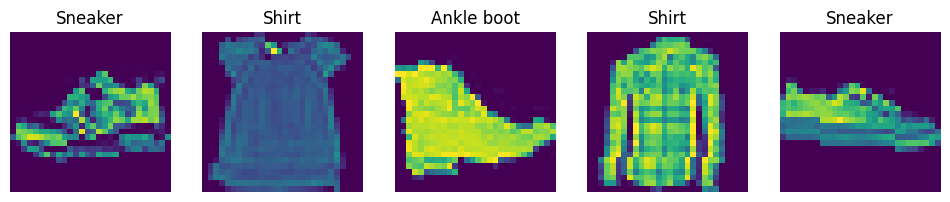

In [39]:

# Initialize Weights & Biases
wandb.init(project='CNN', entity='usf-alpha-neurons', config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "FashionMNIST",
        "epochs": 10,
    },)

# Simulate training.
epochs = 10

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),  # Random rotations
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
full_trainset = torchvision.datasets.FashionMNIST(root=dataset_path, train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg.transpose((1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the class names in FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot a few images from different classes
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].numpy().transpose((1, 2, 0)))
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.show()


In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.LeakyReLU(0.1)(self.bn1(self.conv1(x))))
        x = self.pool(nn.LeakyReLU(0.1)(self.bn2(self.conv2(x))))
        x = self.pool(nn.LeakyReLU(0.1)(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(nn.LeakyReLU(0.1)(self.fc1(x)))
        x = self.fc2(x)
        return x

### **Model, Loss and Optimizer**
* We used **Cross-Entropy Loss** to evaluate the model's performance. It is particularly effective for multi-class classification problems like FashionMNIST, where the model predicts a probability distribution over multiple classes.
* The **AdamW optimizer** is used to update the model's parameters during training, with weight decay for regularization.
* A learning rate scheduler is set up to reduce the learning rate by half after every 5 epochs to help the model converge more efficiently.

In [41]:
# Model, Loss, and Optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


### **Training Function with AMP**
* **Model Setup and Mixed Precision**: We initialize the model and use GradScaler() for mixed precision training, which reduces memory usage and speeds up computation.

* **Training Loop**: For each epoch, we loop through the training batches, move the data to the device, compute the forward pass, calculate the loss, and perform backpropagation with mixed precision.

* **Optimizer and Scheduler**: After calculating gradients, we update the model weights using the optimizer, and the learning rate is adjusted by the scheduler.

* **Validation and Logging**: After each epoch, we evaluate the model on the validation set, calculate validation loss and accuracy, and log the metrics to Weights and Biases for monitoring.


In [42]:
# Training function with AMP and logging additional metrics
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.amp.GradScaler()  # Use GradScaler without 'cuda' in this context

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):  # Fix: Pass device type as string
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)

        # Pass `criterion` to `evaluate_model`
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, valloader, criterion)

        scheduler.step()

        # Log all metrics to WandB
        wandb.log({
            'epoch': epoch + 1,
            'Train Loss': avg_loss,
            'Val Loss': val_loss,
            'Val Accuracy': val_accuracy,
            'Val Precision': val_precision,
            'Val Recall': val_recall,
            'Val F1 Score': val_f1
        })

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")


### **Evaluation Function**
* **Set Model to Evaluation Mode**: We set the model to evaluation mode and disable gradient computation using torch.no_grad() to save memory during inference.

* **Track Loss and Correct Predictions**: For each batch, we calculate the loss and count the correct predictions by comparing model outputs to the true labels.

* **Return Average Loss and Accuracy**: After evaluating all batches, the function returns the average loss and the accuracy of the model on the dataset.

In [43]:
# Evaluation function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    y_true = []
    y_pred = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1



### **Training and Evaluation**
* **Train the Model**: The train_model function trains the model using training data, loss function, optimizer, and scheduler for the specified number of epochs.

* **Evaluate on Test Set**: After training, the model is evaluated on the test dataset to calculate the test loss and accuracy.

* **Log and Print Results**: Test results (loss, precision, accuracy, recall and F1-score) are logged to Weights and Biases (WandB) and printed to the console
for tracking.

In [44]:
# Run training and evaluation
train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10)

# Evaluate on test data
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, testloader, criterion)

# Log test metrics
wandb.log({
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
})

# Print test results
print(f'Accuracy on test set: {test_accuracy:.2f}%')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')


Epoch 1, Loss: 0.5032, Val Loss: 0.3588, Val Accuracy: 86.64%, Precision: 0.8703, Recall: 0.8664, F1 Score: 0.8673
Epoch 2, Loss: 0.3251, Val Loss: 0.3413, Val Accuracy: 87.20%, Precision: 0.8884, Recall: 0.8720, F1 Score: 0.8731
Epoch 3, Loss: 0.2782, Val Loss: 0.2715, Val Accuracy: 90.15%, Precision: 0.9019, Recall: 0.9015, F1 Score: 0.9004
Epoch 4, Loss: 0.2549, Val Loss: 0.2587, Val Accuracy: 90.32%, Precision: 0.9050, Recall: 0.9032, F1 Score: 0.9016
Epoch 5, Loss: 0.2389, Val Loss: 0.2645, Val Accuracy: 90.22%, Precision: 0.9053, Recall: 0.9022, F1 Score: 0.9003
Epoch 6, Loss: 0.1999, Val Loss: 0.2283, Val Accuracy: 91.59%, Precision: 0.9163, Recall: 0.9159, F1 Score: 0.9152
Epoch 7, Loss: 0.1896, Val Loss: 0.2201, Val Accuracy: 92.01%, Precision: 0.9199, Recall: 0.9201, F1 Score: 0.9192
Epoch 8, Loss: 0.1838, Val Loss: 0.2301, Val Accuracy: 91.92%, Precision: 0.9194, Recall: 0.9192, F1 Score: 0.9186
Epoch 9, Loss: 0.1740, Val Loss: 0.2288, Val Accuracy: 92.08%, Precision: 0.9221

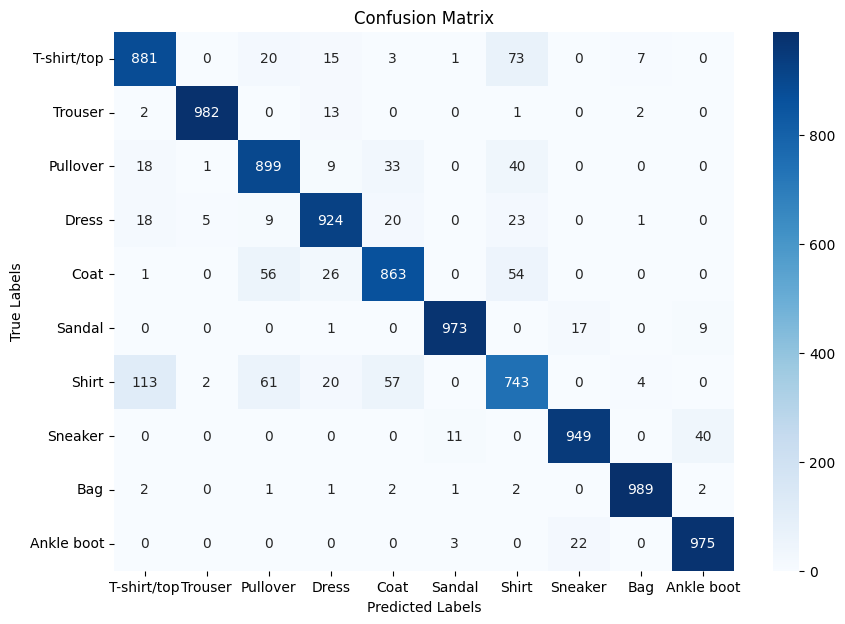

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.88      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.90      0.88      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.88      0.86      0.87      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.79      0.74      0.77      1000
     Sneaker       0.96      0.95      0.95      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy on test set: 91.78%


In [45]:

# Function to plot confusion matrix and classification report
def visualize_evaluation(true_labels, predicted_labels, class_names):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Example usage during evaluation
test_loss, test_accuracy, true_labels, predicted_labels = evaluate_model(model, testloader, criterion)

# Log evaluation results to WandB
wandb.log({'Test Loss': test_loss, 'Test Accuracy': test_accuracy})

# Visualize evaluation results
visualize_evaluation(true_labels, predicted_labels,
                     class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

print(f'Accuracy on test set: {test_accuracy:.2f}%')


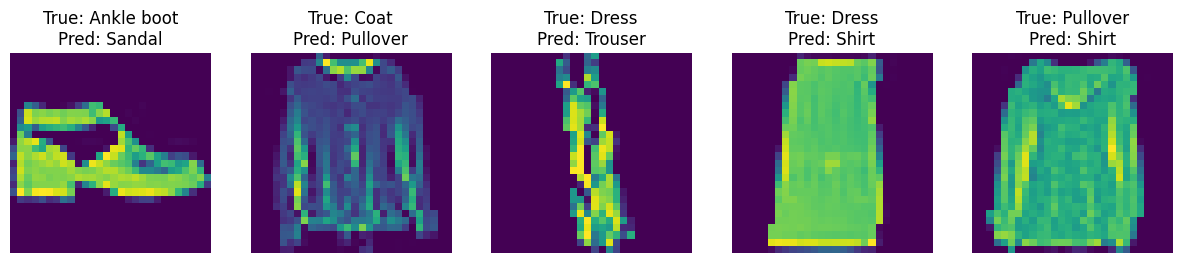

Accuracy on test set: 91.89%


In [46]:
# Updated evaluate_model function to get misclassified images
def evaluate_model_with_misclassifications(model, dataloader, criterion):
    model.eval()
    true_labels = []
    predicted_labels = []
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            # Track misclassified images
            misclassified = (predicted != labels)
            misclassified_images.extend(images[misclassified].cpu())
            misclassified_true_labels.extend(labels[misclassified].cpu().numpy())
            misclassified_pred_labels.extend(predicted[misclassified].cpu().numpy())

    accuracy = 100 * np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy, misclassified_images, misclassified_true_labels, misclassified_pred_labels

# Function to visualize some misclassified images
def visualize_misclassifications(misclassified_images, misclassified_true_labels, misclassified_pred_labels, class_names, num_images=5):
    plt.figure(figsize=(15, 15))

    for i in range(min(num_images, len(misclassified_images))):
        plt.subplot(1, num_images, i+1)
        plt.imshow(misclassified_images[i].permute(1, 2, 0))  # Convert to HWC format for plotting
        true_label = class_names[misclassified_true_labels[i]]
        pred_label = class_names[misclassified_pred_labels[i]]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')

    plt.show()

# Example usage during evaluation
test_loss, test_accuracy, misclassified_images, misclassified_true_labels, misclassified_pred_labels = evaluate_model_with_misclassifications(model, testloader, criterion)

# Log evaluation results to WandB
wandb.log({'Test Loss': test_loss, 'Test Accuracy': test_accuracy})

# Visualize misclassified images
visualize_misclassifications(misclassified_images, misclassified_true_labels, misclassified_pred_labels,
                              class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

print(f'Accuracy on test set: {test_accuracy:.2f}%')


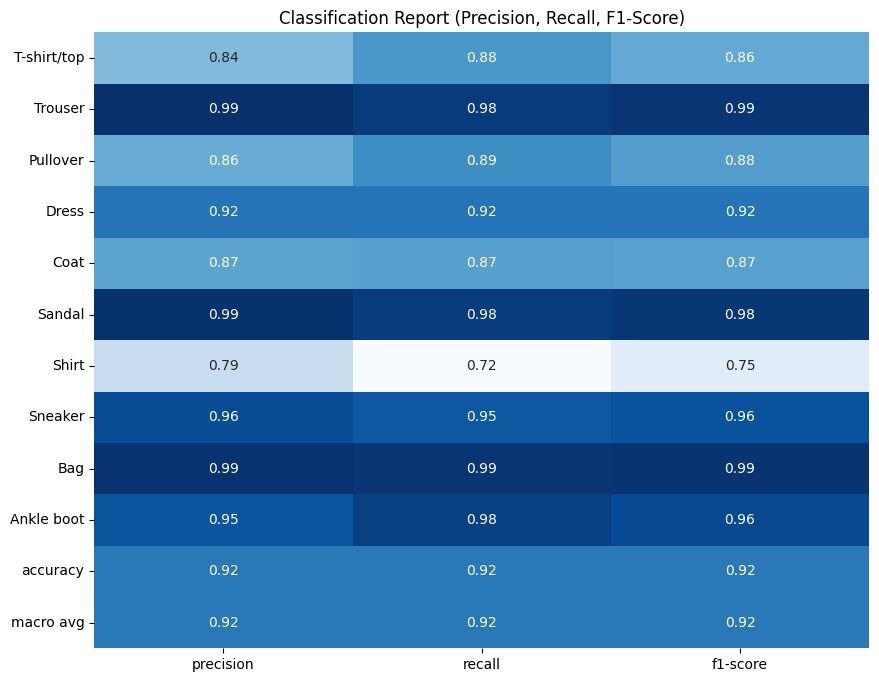

In [47]:
def plot_classification_report(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.iloc[:-1, :-1].astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.title('Classification Report (Precision, Recall, F1-Score)')
    plt.show()

# Example usage:
plot_classification_report(model, testloader, class_names)


### Conclusion:

In this experiment, we trained and evaluated a Convolutional Neural Network (CNN) model for image classification on a dataset of 10 different clothing categories. The model's performance was assessed through various metrics, including accuracy, precision, recall, F1-score, and loss, using both training and validation sets.

Throughout the training process, we employed mixed precision training (AMP) to speed up computations and reduce memory usage, which helped in achieving efficient training on larger datasets. Additionally, we visualized the model's performance using various plots, such as the loss curves over epochs, confusion matrix, and the classification report, which provided insights into the model's strengths and areas for improvement.

Key findings include:
1. The model achieved a **high overall accuracy : __91.8%__** on the test set, indicating that it is performing well in classifying the clothing items.
2. **Precision, recall, and F1-scores** were evaluated for each class, revealing which classes the model struggled with and which it performed well on. Classes with lower scores were identified, potentially guiding future improvements in the model.
3. The **confusion matrix** showed how the model confused different classes with one another, providing a visual representation of misclassifications.
4. **Incorrect predictions** were visualized, allowing us to inspect and analyze specific examples where the model failed to make correct predictions, further guiding adjustments to improve performance.

In conclusion, the model demonstrated solid performance, but there are opportunities to enhance its accuracy and generalization, particularly for classes with lower scores. Future work could focus on further model tuning using hyperparameter tuning, data augmentation, or incorporating more advanced techniques such as transfer learning to improve classification results across all classes.